### Chess Hi-C analysis
This notebook documents my attempt to detect structural changes using CHESS between Legionella-infected and control Acanthamoeba castellanii.

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import warnings
warnings.filterwarnings('ignore')

os.chdir('/home/cyril/Repos/Acastellanii_legionella_infection/')
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/uninfected_merged_subsampled.cool')
clr_inf = cooler.Cooler('data/output/cool/infected_merged_subsampled.cool')

First, I split the genome into overlapping sliding windows. Windows have a size of 100kb (50 bins) and the step size is 2kb (1 bin). I run chess on the control and infected maps to compute a similarity z-score (z-ssim) between conditions for each window.

In [ ]:
%%bash
# Setup dirs
mkdir chess
mkdir chess/features
# Generate chromsizes file
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed
chess sim data/output/cool/uninfected_merged_subsampled.cool \
          data/output/cool/infected_merged_subsampled.cool \
          chess/100kb_win_2kb_step.bed \
          chess/100kb_win_2kb_step_legio_results.tsv -p6

Now we need to filter windows of interest based on two features:
* SN: Signal to noise ratio
* z-ssim: Z-score of similarity

Interesting windows will have a good signal-to-noise ratio and a low similarity score (changes happening between conditions).

In [20]:
### Chess change detection
chess = pd.read_csv('chess/100kb_win_2kb_step_legio_results.tsv', sep='\t')
wins = pd.read_csv('chess/100kb_win_2kb_step.bed', sep='\t', header=None)
chess['start'] = wins.iloc[:, 1]
# Make start position absolute (not relative to chromosome)
chess['abs_start'] = chess['start'].diff().fillna(0)
chromstart = chess.abs_start < 0
chess.abs_start[chromstart] = 1
chess.abs_start = chess.abs_start.cumsum()
# Remember abs position of chromosome starts
chromstart = chess.abs_start[chromstart]

<IPython.core.display.Javascript object>


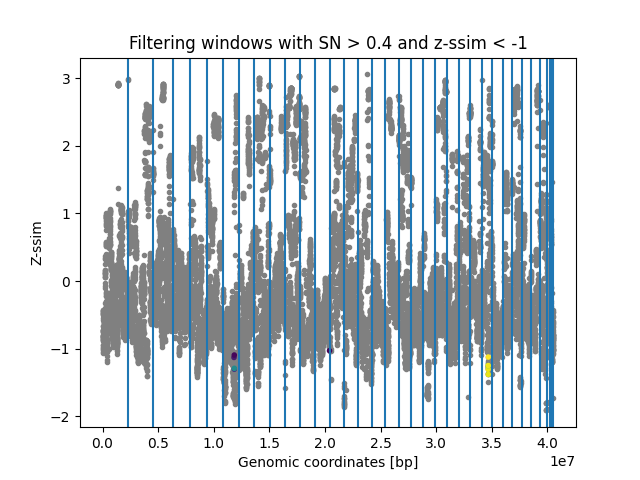

In [3]:
%matplotlib notebook
SN_THRESH = 0.4
ZSSIM_THRESH = -1
hits = (chess.SN > SN_THRESH) & (chess.z_ssim < ZSSIM_THRESH)
plt.scatter(chess.abs_start, chess.z_ssim, c='gray', marker='.')
plt.scatter(chess.abs_start[hits], chess.z_ssim[hits], c=chess.SN[hits], marker='.')
for v in chromstart.values:
    plt.axvline(v)
plt.xlabel("Genomic coordinates [bp]")
plt.ylabel("Z-ssim")
plt.title(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv('chess/100kb_win_2kb_step_filtered.bed', header=None, index=False, sep='\t')

I then use `chess extract` to extract differential features in those filtered windows, and `chess crosscorrelate` to cluster these features by similarity.

In [ ]:
%%bash
chess extract chess/100kb_win_2kb_step_filtered.bed \
              data/output/cool/uninfected_merged_subsampled.cool \
              data/output/cool/infected_merged_subsampled.cool \
              chess/features
chess crosscorrelate chess/features/lost_features.tsv \
                     chess/100kb_win_2kb_step_filtered.bed \
                     ./chess/features

Now let's visualize the automatically extracted features.

In [4]:
from scipy.ndimage import zoom
import scipy.ndimage as ndi
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out


def process_img(img):
    img = np.nan_to_num(img, 0)
    img[img > np.percentile(img, 90)] = np.percentile(img, 90)
    img = clipped_zoom(img, 0.7)
    img = ndi.rotate(img, 45, reshape=False)
    middle = int(np.shape(img)[1]/ 2.)
    return img[:middle,:]

<IPython.core.display.Javascript object>


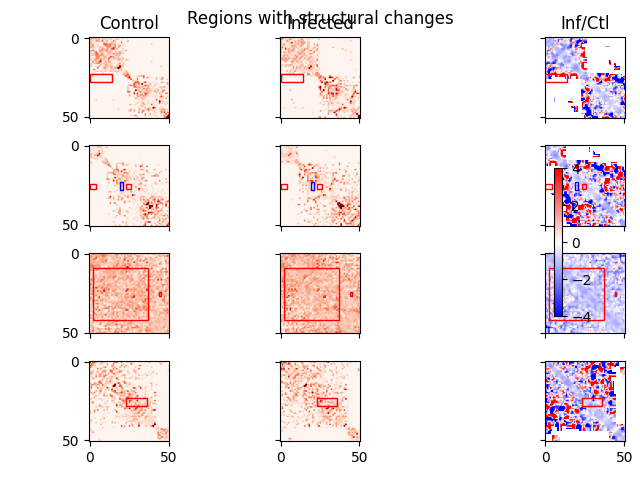

Text(0.5, 0.98, 'Regions with structural changes')

In [21]:
%matplotlib notebook
from chromosight.utils.preprocessing import detrend
from matplotlib.patches import Rectangle
import scipy.ndimage as ndi

# Load features
clusters = pd.read_csv(
    'chess/features/subregions_3_clusters_lost.tsv',
    sep='\t',
    names=['cluster', 'coords', 'ft'])
clusters['coords'] = clusters.coords.str.replace(r':\+-.*', '')
lost_ft = pd.read_csv(
    'chess/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
gained_ft = pd.read_csv(
    'chess/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
# Identify all windows (regions) to plot
# Multiple features can be in the same region
wins_ft = np.unique(lost_ft.win)
# Discard adjacent windows...
wins_ft = np.insert(wins_ft[1:][np.diff(wins_ft) > 1], 0, wins_ft[0])

fig, ax = plt.subplots(len(wins_ft), 3, sharex=True, sharey=True)
for i, w in enumerate(wins_ft):
    ft = lost_ft.loc[lost_ft.win == w, 'ft'].values[0]
    chrom, start, end = wins.loc[wins.iloc[:, 6] == w, [0, 1, 2]].values[0]    
    reg = f'{chrom}:{start}-{end}'
    reg_s, reg_e = clr_ctl.extent(reg)
    lost_curr = lost_ft.loc[lost_ft.win == w , :]
    gained_curr = gained_ft.loc[gained_ft.win == w, :]
    mat_ctl = clr_ctl.matrix(sparse=True, balance=True).fetch(reg)
    mat_inf = clr_inf.matrix(sparse=True, balance=True).fetch(reg)
    ax[i, 0].imshow(detrend(mat_ctl).toarray(), cmap='Reds', vmax=4)
    ax[i, 1].imshow(detrend(mat_inf).toarray(), cmap='Reds', vmax=4)
    mat_inf = ndi.gaussian_filter(mat_inf.toarray(), sigma=.5)
    mat_ctl = ndi.gaussian_filter(mat_ctl.toarray(), sigma=.5)
    x = ax[i, 2].imshow(np.log2(mat_inf / mat_ctl), cmap='bwr', vmax=4, vmin=-4)
    for _, r in lost_curr.iterrows():
        for a in ax[i, :]:
            a.add_patch(
                Rectangle(
                    (r.xmin, r.ymin),
                    r.xmax - r.xmin,
                    r.ymax - r.ymin,
                    facecolor='none',
                    edgecolor='red'
                )
            )
    for _, r in gained_curr.iterrows():
        for a in ax[i, :]:
            a.add_patch(
                Rectangle(
                    (r.xmin, r.ymin),
                    r.xmax - r.xmin,
                    r.ymax - r.ymin,
                    facecolor='none',
                    edgecolor='blue'
                )
            )

    
ax[0, 0].set_title("Control")
ax[0, 1].set_title("Infected")
ax[0, 2].set_title("Inf/Ctl")
fig.colorbar(x, ax=ax[:, 2], shrink=0.4, location='right')
plt.tight_layout()
plt.suptitle('Regions with structural changes')

When using recommended (pretty stringent) filters, CHESS identifies two regions undergoing structural changes during infection. Now let's have a look at genes located in these neighbourhoods

In [8]:
diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

The first region spans scaffold_7:982002-1110001 when concatenating all windows involved. In this region, there is a border shift around bin 20. This shift enlarges a domain containing two genes:
* An AMP binding enzyme domain containing protein
* A fascin subfamily protein. [According to NCBi](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00257) these protein are involved in phosphorylation and bind actin. Could be interesting in the context of Legio infection ? (signaling + vesicle transport)

In [39]:
def query_ucsc_df(query, df):
    r_chrom, bp = query.split(':')
    r_start, r_end = map(int, bp.split('-'))
    result = df.query(f'(chrom == "{r_chrom}") & (end >= {r_start}) & (start < {r_end})')
    return result
    
def map_annot_viz(viz_range, genes_df):
    local_genes = query_ucsc_df(viz_range, genes_df)
    r_start = int(viz_range.split(':')[1].split('-')[0])
    local_genes['bin'] = local_genes['start'] // 2000 - r_start//2000
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    annot_col = ['grey' if a == 'hypothetical protein' else 'blue' for a in local_genes.desc]
    ax[0].imshow(detrend(clr_ctl.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[1].imshow(detrend(clr_inf.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[0].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[1].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    for i, g in local_genes.iterrows():
        if g.desc != 'hypothetical protein':
            ax[2].annotate(s=g.desc[:50], xy=(0.1, g.bin), fontsize=5)

<IPython.core.display.Javascript object>


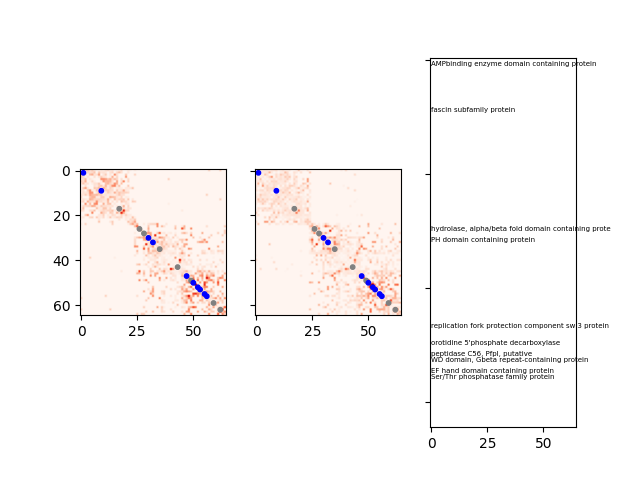

In [40]:
%matplotlib notebook

range_1 = 'scaffold_7:982002-1110001'
map_annot_viz(range_1, liftover)

The second region spans scaffold_13:1308001-1408001 when concatenating all windows involved. The feature is not so clear here, but we can see a strengthening cross pattern around bin 38. The genes that seem to be involved in this cross (i.e. put into contact) are:
* An aminotransferase (class V)
* Hydroxymethyltransferase
* Homoserine acetyltransferase
* A Rho GAP (GTPase) domain containing protein
* A leucine rich repeat domain containing protein.

> Note: In the viscinity of the cross, there are also an Ankyrin repeat containing protein and a DIL domain containing protein([According to interpro](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002710/), this is an actin-based molecular motor for cargo transport).



<IPython.core.display.Javascript object>


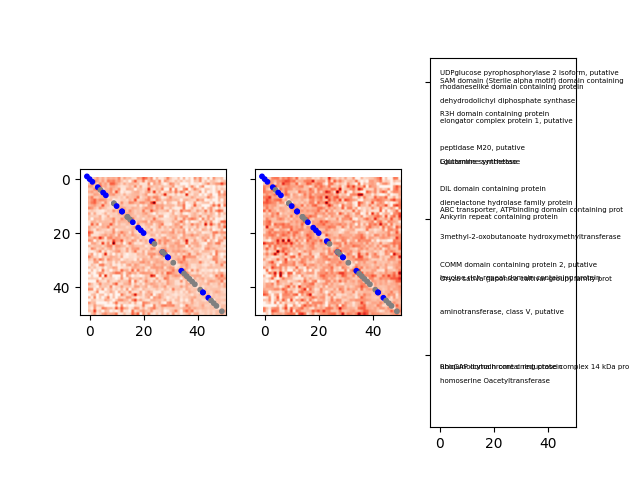

In [41]:
%matplotlib notebook
range_2 = 'scaffold_13:1308001-1408001'
map_annot_viz(range_2, liftover)

The third region spans scaffold_26:590002-698001 when concatenating all windows involved. It's hard to see what change there is, CHESS seems to think it is the tiny looping interaction around bin 35. Which would involve only two genes:
* ribonuclease HI
* A NmrAlike family protein

<IPython.core.display.Javascript object>


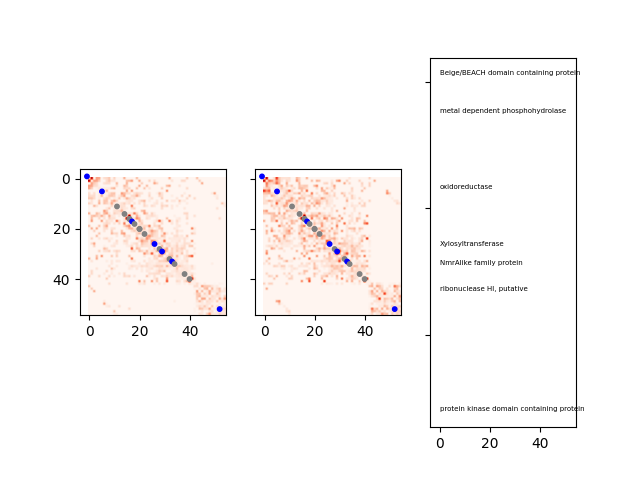

In [42]:
%matplotlib notebook
range_3 = 'scaffold_26:590002-698001'
map_annot_viz('scaffold_26:590002-698001', liftover)

### Differential expression

Now that we have identified a group of genes with 3D changes, let's check whether their expression also changes during infection.

In [27]:
diff_expr

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3
0,ACA1_000210,474.681614,-0.673862,0.203958,-3.303921,0.000953,0.002987,NaN
1,ACA1_000220,109.068615,-0.394487,0.181319,-2.175652,0.029581,0.057943,FUN_011364
2,ACA1_000330,344.708090,0.454608,0.111475,4.078131,0.000045,0.000202,NaN
3,ACA1_000530,312.524574,-0.653631,0.179799,-3.635355,0.000278,0.001005,FUN_001668
4,ACA1_000540,312.324909,-0.224862,0.143575,-1.566162,0.117311,0.185845,FUN_001669
...,...,...,...,...,...,...,...,...
16061,ACA1_400590,499.255288,0.220975,0.078907,2.800463,0.005103,0.012838,FUN_004281
16062,ACA1_400800,275.775852,0.321421,0.150552,2.134951,0.032765,0.063347,FUN_004281
16063,ACA1_400910,603.799901,0.331212,0.136062,2.434277,0.014922,0.032327,FUN_004281
16064,ACA1_401020,343.682286,0.428377,0.169451,2.528024,0.011471,0.025754,FUN_004282


In [85]:
# Gather list of gene accessions in any of the three regions reported by Chess
chess_acc = np.unique(pd.concat([query_ucsc_df(q, liftover) for q in [range_1, range_2, range_3]])['accession'])

<IPython.core.display.Javascript object>


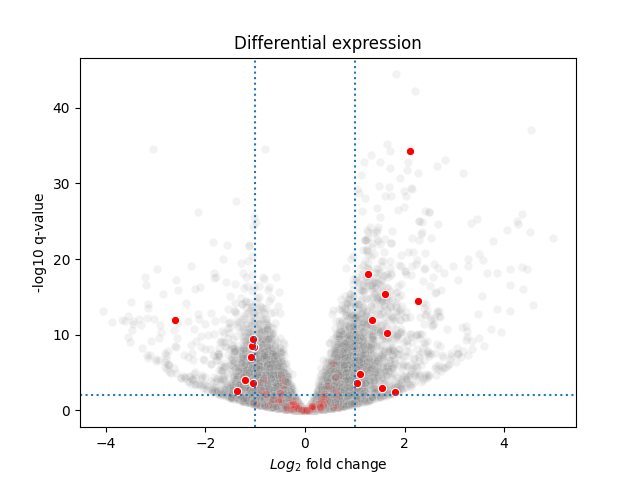

Text(0.5, 1.0, 'Differential expression')

In [90]:
%matplotlib notebook
FC = 1 # Threshold for log2 fold change
PLOG = 2 # Threshold for -log10(pvalue)
diff_expr['logpval'] = -np.log10(diff_expr.padj)
chess_genes = diff_expr.loc[diff_expr.accession.isin(chess_acc), :]
candidates = chess_genes.loc[(diff_expr.logpval > PLOG) & (diff_expr.log2FoldChange.abs() > FC), :]
sns.scatterplot(data=diff_expr, x='log2FoldChange', y='logpval', color='grey', alpha=0.1)
sns.scatterplot(data=chess_genes, x='log2FoldChange', y='logpval', color='red', alpha=0.1)
sns.scatterplot(data=candidates, x='log2FoldChange', y='logpval', color='red')
plt.axvline(FC, ls=':')
plt.axvline(-FC, ls=':')
plt.axhline(PLOG, ls=':')
plt.xlabel("$Log_2$ fold change")
plt.ylabel("-log10 q-value")
plt.title("Differential expression")

Here is the list of differentially expressed genes which fall in regions from CHESS:

In [91]:
candidates

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,logpval
878,ACA1_036920,716.374178,-1.019513,0.161403,-6.316573,2.670000e-10,3.970000e-09,FUN_002670,8.401209
879,ACA1_036930,275.291529,1.611144,0.186655,8.631663,6.050000e-18,3.670000e-16,FUN_002670,15.435334
880,ACA1_036940,443.021634,1.099382,0.233562,4.707018,2.510000e-06,1.540000e-05,FUN_002671,4.812479
881,ACA1_036950,848.081548,1.048619,0.260581,4.024162,5.720000e-05,2.491303e-04,FUN_002671,3.603573
909,ACA1_037430,151.806899,-1.088226,0.189528,-5.741769,9.370000e-09,1.000000e-07,FUN_002690,7.000000
910,ACA1_037440,192.775783,-1.068832,0.168594,-6.339695,2.300000e-10,3.480000e-09,FUN_002690,8.458421
5498,ACA1_122760,326.622903,1.264990,0.135434,9.340268,9.610000e-21,9.510000e-19,FUN_008196,18.021819
6927,ACA1_158840,16.709061,1.542602,0.430210,3.585694,3.361832e-04,1.191068e-03,FUN_008180,2.924063
6936,ACA1_158930,251.482171,-1.045477,0.256987,-4.068213,4.740000e-05,2.101746e-04,FUN_008186,3.677420
6943,ACA1_158990,154.282749,2.262448,0.271445,8.334818,7.760000e-17,3.980000e-15,FUN_008193,14.400117


And corresponding annotations (excluding genes without annotations):

In [92]:
liftover.loc[liftover.accession.isin(candidates.accession), :].query('desc != "hypothetical protein"')

,chrom,type,start,end,attr,accession,desc
41434,scaffold_13,gene,1311135,1313828,ID=gene:ACA1_036920;biotype=protein_coding;des...,ACA1_036920,rhodaneselike domain containing protein
41454,scaffold_13,gene,1314564,1316069,ID=gene:ACA1_036930;biotype=protein_coding;des...,ACA1_036930,dehydrodolichyl diphosphate synthase
41476,scaffold_13,gene,1318686,1320655,ID=gene:ACA1_036950;biotype=protein_coding;des...,ACA1_036950,R3H domain containing protein
131546,scaffold_26,gene,601094,602861,ID=gene:ACA1_158840;biotype=protein_coding;des...,ACA1_158840,metal dependent phosphohydrolase
131668,scaffold_26,gene,642215,643937,ID=gene:ACA1_122760;biotype=protein_coding;des...,ACA1_122760,Xylosyltransferase
131700,scaffold_26,gene,648304,649778,ID=gene:ACA1_159010;biotype=protein_coding;des...,ACA1_159010,NmrAlike family protein
196139,scaffold_7,gene,1082810,1085949,ID=gene:ACA1_269680;biotype=protein_coding;des...,ACA1_269680,orotidine 5'phosphate decarboxylase
196203,scaffold_7,gene,1093388,1094310,ID=gene:ACA1_269720;biotype=protein_coding;des...,ACA1_269720,EF hand domain containing protein
